In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline 

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

SEED = 18
VALID_SIZE = 0.25
PATH = ''

In [2]:
train_data = pd.read_csv(PATH + 'contest_train.csv')
test_data = pd.read_csv(PATH + 'contest_test.csv')

## Data Analysis

In [3]:
train_data.head()

,ID,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,...,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259,TARGET
0,737005990,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-13.093355,22.223191,...,0.0,65.729608,68.566610,0.0,0.0,0.0,1.0,1.0,1.0,0
1,336625142,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.920928,-14.228085,...,0.0,70.623966,72.159259,1.0,0.0,0.0,1.0,1.0,1.0,0
2,1146317240,12.0,5.0,0.0,0.0,0.0,0.0,0.0,-62.402398,-18.135059,...,1.0,475.810787,603.267435,1.0,1.0,0.0,2.0,1.0,1.0,2
3,1152334700,59.0,5.0,0.0,0.0,0.0,0.0,0.0,-25.523791,-11.967182,...,0.0,140.543320,212.539669,1.0,1.0,0.0,1.0,1.0,2.0,0
4,1148871905,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-14.628149,-23.565047,...,2.0,417.804418,430.329005,0.0,1.0,0.0,1.0,2.0,1.0,1


In [4]:
test_data.head()

,ID,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,84728433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.265322,110.813724,...,0.0,0.0,436.883761,427.497873,0.0,1.0,0.0,1.0,1.0,1.0
1,335016156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.316538,14.427879,...,0.0,0.0,53.400612,58.863404,1.0,1.0,0.0,1.0,1.0,1.0
2,1163752045,16.0,4.0,0.0,0.0,0.0,0.0,1.0,457.087009,1172.556882,...,131.0,151.0,217.419547,490.478263,0.0,1.0,0.0,1.0,1.0,1.0
3,84929758,2.0,1.0,0.0,0.0,0.0,0.0,0.0,29.672314,58.511494,...,0.0,0.0,657.453708,692.191717,1.0,1.0,0.0,2.0,1.0,1.0
4,143090121,2.0,1.0,0.0,0.0,1.0,0.0,0.0,522.148408,2724.481080,...,50.0,188.0,1253.064074,1670.514312,0.0,1.0,0.0,1.0,1.0,2.0


In [5]:
# Соотношение числа объектов в учебной и тестовой выборке
print('Train DF size: {} ({:.1%})'.format(train_data.shape[0], \
                            train_data.shape[0] / (train_data.shape[0] + test_data.shape[0])))
print('Test DF size: {} ({:.1%})'.format(test_data.shape[0], \
                            test_data.shape[0] / (train_data.shape[0] + test_data.shape[0])))

Train DF size: 18390 (75.0%)
Test DF size: 6131 (25.0%)


In [6]:
# Распределение классов в учебной выборке
train_data['TARGET'].value_counts()

0    13029
1     4237
2     1124
Name: TARGET, dtype: int64

In [7]:
# Посмотрим на признаки с минимальным количеством значений с учетом пропущенных
train_data.nunique(dropna=False).sort_values()[:10]

FEATURE_256    1
FEATURE_144    1
FEATURE_3      1
FEATURE_249    1
FEATURE_15     2
FEATURE_18     2
FEATURE_140    2
FEATURE_11     2
FEATURE_19     2
FEATURE_159    2
dtype: int64

Признаки FEATURE_144, FEATURE_3, FEATURE_256, FEATURE_249 не несут никакой полезной информации, можно их удалить.

In [8]:
del_features = ['FEATURE_3', 'FEATURE_144', 'FEATURE_249', 'FEATURE_256']
train_data.drop(del_features, axis=1, inplace=True)
test_data.drop(del_features, axis=1, inplace=True)

In [9]:
# Проверим наличие пропусков в данных
print(sum(train_data.isna().sum()), sum(test_data.isna().sum()))
# Пропуски в первых 15 объектах
train_data.isna().sum(axis=1).head(15)

107967 36128


0      7
1      7
2      2
3      6
4      1
5      6
6      3
7      1
8     13
9     10
10     8
11     7
12     7
13     8
14     6
dtype: int64

In [10]:
# Функция для отображения информации о пропущенных данных
def missing_info(df):
    missing_df = df.isna().sum().to_frame()
    missing_df.columns=['missing']
    mis_feat_count = missing_df[missing_df['missing'] > 0].shape[0]
    missing_df['percentage'] = round(100 * missing_df['missing'] / df.shape[0], 2)
    print(missing_df[missing_df['missing'] > 0].sort_values(by='missing', ascending=False))
    print('Total features with missing values: {} / {} ({:.1%})' \
          .format(mis_feat_count, missing_df.shape[0], mis_feat_count / missing_df.shape[0]))

In [11]:
missing_info(train_data)

             missing  percentage
FEATURE_189    18146       98.67
FEATURE_194    12952       70.43
FEATURE_190    12889       70.09
FEATURE_191    11451       62.27
FEATURE_192     9752       53.03
FEATURE_193     9382       51.02
FEATURE_187     8857       48.16
FEATURE_71      2189       11.90
FEATURE_73      2189       11.90
FEATURE_195     2074       11.28
FEATURE_72      2069       11.25
FEATURE_153     1824        9.92
FEATURE_151     1824        9.92
FEATURE_152     1824        9.92
FEATURE_150     1824        9.92
FEATURE_149     1824        9.92
FEATURE_8        893        4.86
FEATURE_188      773        4.20
FEATURE_162      487        2.65
FEATURE_196      356        1.94
FEATURE_137      218        1.19
FEATURE_131      218        1.19
FEATURE_123      218        1.19
FEATURE_124      218        1.19
FEATURE_125      218        1.19
FEATURE_126      218        1.19
FEATURE_138      218        1.19
FEATURE_128      218        1.19
FEATURE_129      218        1.19
FEATURE_13

Можно заметить, что некоторые признаки имеют одинаковое или близкое количество пропусков, что, вероятно, неслучайно. Отметим группы таких признаков:
- FEATURE_175, FEATURE_181, FEATURE_203, FEATURE_204, FEATURE_205, FEATURE_206, FEATURE_207, FEATURE_208 (91-98 пропусков)
- FEATURE_123, FEATURE_124, FEATURE_125, FEATURE_126, FEATURE_127, FEATURE_128, FEATURE_129, FEATURE_130, FEATURE_131, FEATURE_132, FEATURE_133, FEATURE_134, FEATURE_135, FEATURE_136, FEATURE_137, FEATURE_138 (218 пропусков)
- FEATURE_149, FEATURE_150, FEATURE_151, FEATURE_152, FEATURE_153 (1824 пропуска)
- FEATURE_72, FEATURE_195 (2069, 2074 пропусков)
- FEATURE_71, FEATURE_73 (2189 пропусков)

In [12]:
missing_info(test_data)

             missing  percentage
FEATURE_189     6050       98.68
FEATURE_190     4303       70.18
FEATURE_194     4293       70.02
FEATURE_191     3858       62.93
FEATURE_192     3308       53.96
FEATURE_193     3214       52.42
FEATURE_187     3021       49.27
FEATURE_71       771       12.58
FEATURE_73       771       12.58
FEATURE_195      713       11.63
FEATURE_72       712       11.61
FEATURE_153      594        9.69
FEATURE_151      594        9.69
FEATURE_152      594        9.69
FEATURE_150      594        9.69
FEATURE_149      594        9.69
FEATURE_188      291        4.75
FEATURE_8        251        4.09
FEATURE_162      145        2.37
FEATURE_196      111        1.81
FEATURE_137       65        1.06
FEATURE_131       65        1.06
FEATURE_123       65        1.06
FEATURE_124       65        1.06
FEATURE_125       65        1.06
FEATURE_126       65        1.06
FEATURE_138       65        1.06
FEATURE_128       65        1.06
FEATURE_129       65        1.06
FEATURE_13

Видим, что для тестовых объектов эти группы признаков совпадают.

In [13]:
# Проверим, нет ли признаков, дублирующих друг друга
# Для этого сначала объединим учебный и тестовый датафрейм
traintest = pd.concat((train_data.drop('TARGET', axis=1), test_data), axis=0)
# Сделаем датафрейм, являющийся LabelEncoding от объединенного датафрейма
train_enc = pd.DataFrame(index=train_data.index)
for col in tqdm(traintest.columns):
    train_enc[col] = pd.factorize(train_data[col])[0]

100%|██████████████████████████████████████| 257/257 [00:00<00:00, 1157.32it/s]


In [14]:
# Проведем поиск дублирующихся колонок
dupl_cols = {} # Словарь дублирующихся колонок
for ind, col1 in enumerate(tqdm(train_enc.columns)):
    for col2 in train_enc.columns[ind + 1:]:
        if col1!='ID' and col2 not in dupl_cols and train_enc[col2].nunique() < train_enc.shape[0] \
                and np.all(train_enc[col1] == train_enc[col2]):
            dupl_cols[col2] = col1
dupl_cols

100%|████████████████████████████████████████| 257/257 [00:14<00:00, 18.16it/s]


{'FEATURE_73': 'FEATURE_71',
 'FEATURE_128': 'FEATURE_127',
 'FEATURE_129': 'FEATURE_127',
 'FEATURE_130': 'FEATURE_127',
 'FEATURE_135': 'FEATURE_127',
 'FEATURE_136': 'FEATURE_127',
 'FEATURE_137': 'FEATURE_127',
 'FEATURE_138': 'FEATURE_127',
 'FEATURE_200': 'FEATURE_184'}

In [15]:
# Удалим дублирующиеся колонки
train_data.drop(dupl_cols.keys(), axis=1, inplace=True)
test_data.drop(dupl_cols.keys(), axis=1, inplace=True)

In [16]:
# Внимательнее посмотрим на кол-во значений по разным признакам
n_unique = train_data.nunique(dropna=False)
n_unique[:60]

ID            18390
FEATURE_0       152
FEATURE_1        21
FEATURE_2         2
FEATURE_4         2
FEATURE_5         2
FEATURE_6         2
FEATURE_7     18390
FEATURE_8     17498
FEATURE_9         9
FEATURE_10        6
FEATURE_11        2
FEATURE_12    18376
FEATURE_13      156
FEATURE_14       22
FEATURE_15        2
FEATURE_16        2
FEATURE_17        2
FEATURE_18        2
FEATURE_19        2
FEATURE_20       13
FEATURE_21    18390
FEATURE_22      311
FEATURE_23    18390
FEATURE_24    18390
FEATURE_25      325
FEATURE_26    18390
FEATURE_27       30
FEATURE_28       26
FEATURE_29       28
FEATURE_30       25
FEATURE_31       12
FEATURE_32       13
FEATURE_33    18390
FEATURE_34    18390
FEATURE_35    18390
FEATURE_36    18390
FEATURE_37    18390
FEATURE_38    18390
FEATURE_39      557
FEATURE_40      554
FEATURE_41      407
FEATURE_42      354
FEATURE_43      307
FEATURE_44      308
FEATURE_45    18390
FEATURE_46    18390
FEATURE_47    18390
FEATURE_48    18390
FEATURE_49    18390


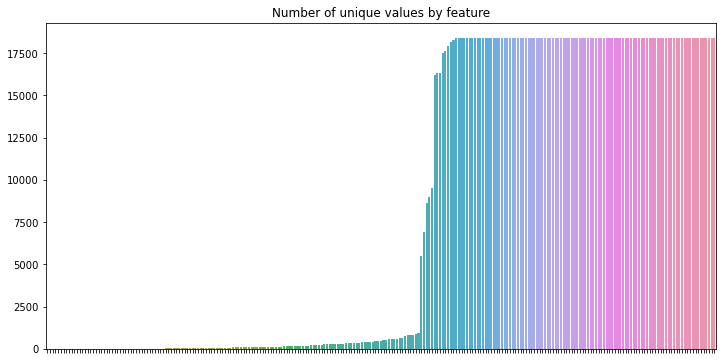

In [17]:
uniq_count = train_data.nunique().sort_values()
plt.figure(figsize=(12, 6))
bar = sns.barplot(x=uniq_count.index, y=uniq_count.values);
bar.set(xticklabels=[])
plt.title('Number of unique values by feature');
plt.show();

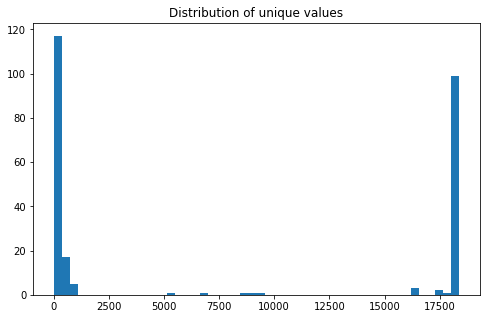

In [18]:
plt.figure(figsize=(8, 5))
plt.hist(n_unique, bins=50);
plt.title('Distribution of unique values');

Явно выделяются две большие группы признаков: ~140 признаков имеют малое количество значений, в то время как ~110 признаков имеют уникальные значения для каждого или почти каждого объекта.

In [19]:
# Признаки с большим количеством значений
mask_high = (n_unique > 15000)
train_data.loc[:, mask_high].head(10)

,ID,FEATURE_7,FEATURE_8,FEATURE_12,FEATURE_21,FEATURE_23,FEATURE_24,FEATURE_26,FEATURE_33,FEATURE_34,...,FEATURE_230,FEATURE_232,FEATURE_233,FEATURE_235,FEATURE_236,FEATURE_237,FEATURE_240,FEATURE_244,FEATURE_252,FEATURE_253
0,737005990,-13.093355,22.223191,533.055545,3.540889,6.010374,-1.345941,-2.317090,45.595312,31.056361,...,-7.645600,-14.982662,-19.907022,235.351475,253.090095,522.408476,111.195748,68.404615,65.729608,68.566610
1,336625142,1.920928,-14.228085,77.445949,0.851897,-6.911539,4.005305,18.030389,-44.228516,2.888951,...,172.464703,22.196969,-17.165290,218.603504,159.369864,360.620216,126.430181,19.842984,70.623966,72.159259
2,1146317240,-62.402398,-18.135059,1281.588378,-2.311606,-4.745698,15.256723,-9.288372,32.411244,-49.744630,...,-61.600884,5.951927,-57.097177,-59.050594,19.118281,69.189937,497.857030,412.343922,475.810787,603.267435
3,1152334700,-25.523791,-11.967182,56.682700,3.461721,-14.979268,6.584476,2.083072,779.596729,1484.581743,...,1785.323470,466.465588,2258.628830,193.300050,104.370575,209.954911,222.525255,185.679568,140.543320,212.539669
4,1148871905,-14.628149,-23.565047,-20.958395,21.588033,-117.359680,-90.086607,-40.119378,119.828164,582.644326,...,724.355084,10557.892419,11361.288572,28.726988,81.362621,115.723697,929.868814,409.829116,417.804418,430.329005
5,85690544,-4.624832,115.362087,85.376112,-107.630248,-97.049286,-96.748794,-23.489715,34.012649,67.386025,...,34.726731,-13.938448,38.864925,107.966433,62.489677,224.108534,292.593039,88.328962,186.220864,155.002126
6,58920504,18.557529,-23.689251,-23.290223,-5.516319,-9.298726,-2.742949,22.110462,9.770246,-7.286785,...,8.222888,420.333808,523.037256,307.427535,264.752677,588.981971,294.679604,253.738277,271.545377,296.854125
7,566065806,-10.768837,-2.124806,16.764395,201.248443,200.095251,200.012230,38.132325,2.153277,41.135466,...,120.238004,50.187632,208.004113,284.028767,933.772521,1171.541743,150.496096,129.038459,169.054136,132.040676
8,10220064363,19.555237,-4.291751,-83.677441,6.366729,-4.780003,4.323665,-13.583574,51.729053,-61.295800,...,67.069895,-20.424246,-3.927773,190.004691,146.089051,351.317433,55.944619,4.449446,45.434471,134.799443
9,1019158443,7.347430,14.152387,-67.360284,10.364155,12.290586,0.832332,68.624652,49.481160,37.044832,...,-166.701988,8.692356,61.596451,32.519271,187.898652,225.448712,174.791594,-0.658464,108.706291,177.318579


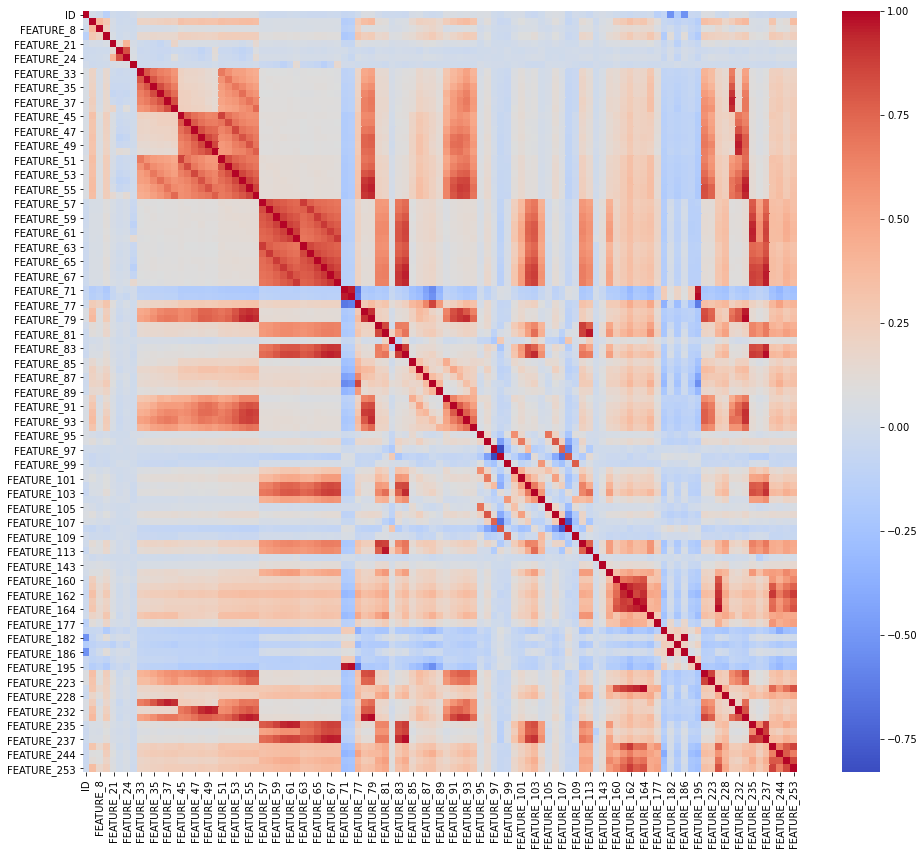

In [20]:
# Посмотрим на корреляцию признаков с большим количеством значений
plt.figure(figsize=(16, 14));
sns.heatmap(train_data.loc[:, mask_high].corr(), cmap= 'coolwarm');

In [21]:
# Подробнее рассмотрим одну из групп таких признаков
insp_features = ['FEATURE_21', 'FEATURE_23', 'FEATURE_24', 'FEATURE_26']
train_data[insp_features].head(15)

,FEATURE_21,FEATURE_23,FEATURE_24,FEATURE_26
0,3.540889,6.010374,-1.345941,-2.317090
1,0.851897,-6.911539,4.005305,18.030389
2,-2.311606,-4.745698,15.256723,-9.288372
3,3.461721,-14.979268,6.584476,2.083072
4,21.588033,-117.359680,-90.086607,-40.119378
5,-107.630248,-97.049286,-96.748794,-23.489715
6,-5.516319,-9.298726,-2.742949,22.110462
7,201.248443,200.095251,200.012230,38.132325
8,6.366729,-4.780003,4.323665,-13.583574
9,10.364155,12.290586,0.832332,68.624652


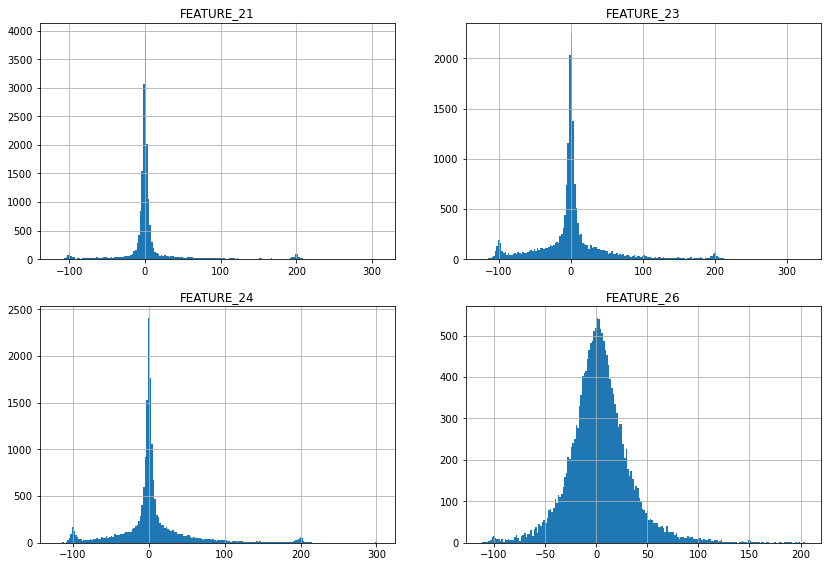

In [22]:
plt.figure(figsize = (14, 20))
i = 0
for col in insp_features:
    plt.subplot(4,2,i+1)
    plt.title(col)
    train_data[col].hist(bins=200)
    i += 1

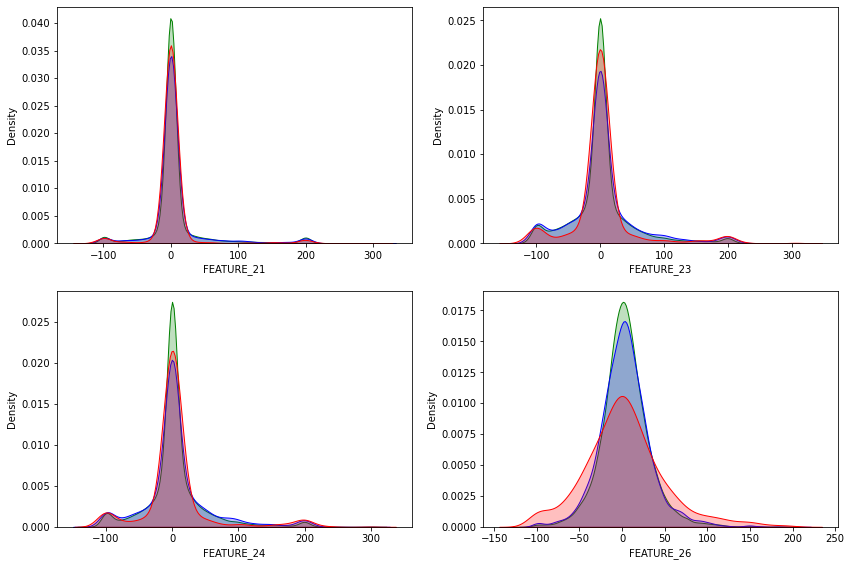

In [23]:
plt.figure(figsize = (14, 20))
i = 0
for col in insp_features:
    plt.subplot(4,2,i+1)
    sns.kdeplot(train_data[col][train_data['TARGET'] == 0], color='green', shade=True);
    sns.kdeplot(train_data[col][train_data['TARGET'] == 1], color='blue', shade=True);
    sns.kdeplot(train_data[col][train_data['TARGET'] == 2], color='red', shade=True);
    i += 1

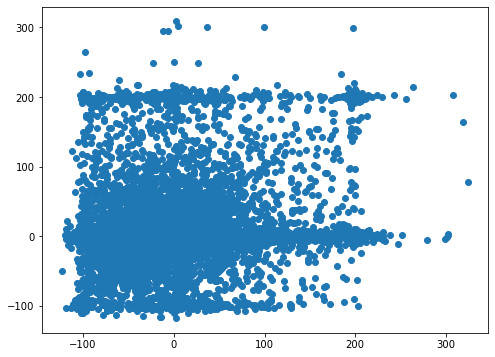

In [24]:
plt.figure(figsize = (8, 6))
plt.scatter(train_data['FEATURE_23'], train_data['FEATURE_21']);

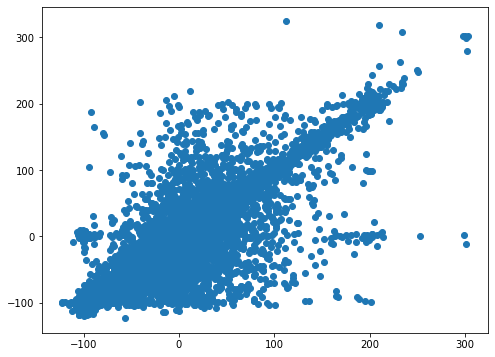

In [25]:
plt.figure(figsize = (8, 6))
plt.scatter(train_data['FEATURE_24'], train_data['FEATURE_23']);

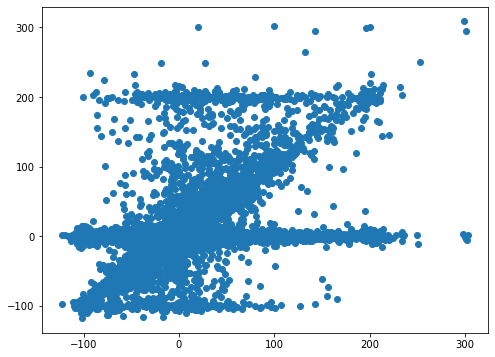

In [26]:
plt.figure(figsize = (8, 6))
plt.scatter(train_data['FEATURE_24'], train_data['FEATURE_21']);

Можем явно различить концентрацию значений данных признаков вокруг "круглых" чисел - -100, 0, 100, 200, 300. Возможно, речь идет о каких-то покупках, оплатах, списаниях бонусов и т.п., т.к. для многих людей в этом случае привычно оперировать суммами, кратными 100. 

In [27]:
# Признаки с малым количеством значений
mask_low = (n_unique < 1000)
train_data.loc[:, mask_low].head(10)

,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_13,...,FEATURE_247,FEATURE_248,FEATURE_250,FEATURE_251,FEATURE_254,FEATURE_255,FEATURE_257,FEATURE_258,FEATURE_259,TARGET
0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0
1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0
2,12.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,...,1.0,3.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,2
3,59.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,5.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,2.0,0.0,1.0,1.0,2.0,1.0,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,4.0,35.0,0.0,1.0,1.0,1.0,1.0,1.0,0
7,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,2.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,61.0,0.0,1.0,0.0,1.0,2.0,2.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,25.0,0.0,1.0,1.0,1.0,2.0,2.0,0


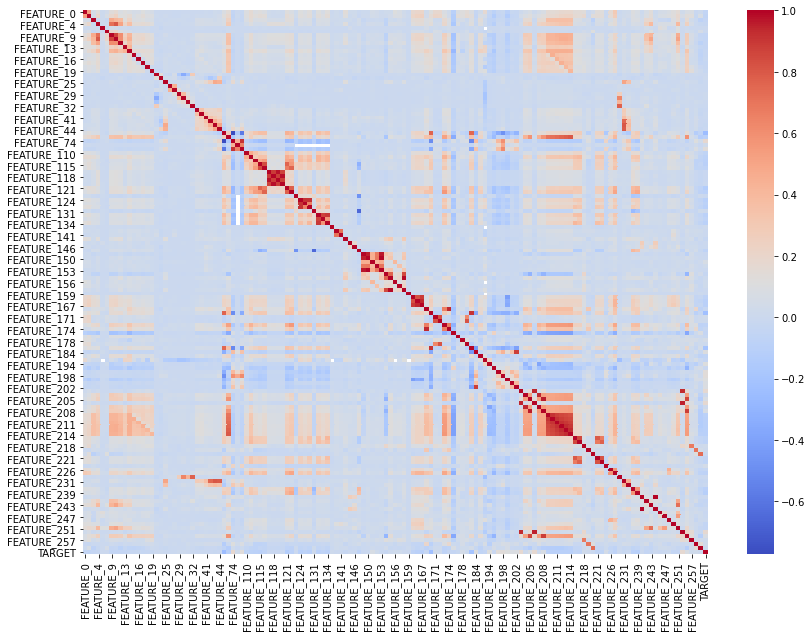

In [28]:
plt.figure(figsize=(14, 10));
sns.heatmap(train_data.loc[:, mask_low].corr(), cmap= 'coolwarm');

В обоих случаях (признаки с большим / с малым числом значений) можно заметить последовательности признаков, тесно связанных друг с другом, т.е. колонки в датафрейме имеют неслучайный порядок.

Если отдельно проинспектировать признаки, можно сделать предположения о природе некоторых из них.

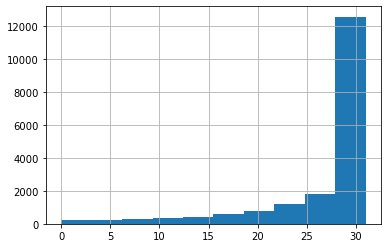

In [29]:
# Возможно, FEATURE_69 и FEATURE_70 содержат количество дней (в каком-то месяце?)
train_data['FEATURE_69'].hist();

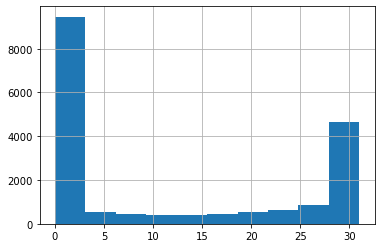

In [30]:
train_data['FEATURE_70'].hist();

In [31]:
# Если разделить значения данного признака на его минимальное ненулевое значение (0.032258), получим целые числа.
# Само же число 0.032258 является результатом деления 1 / 31.
# Возможно, данный признак содержит среднее значение какой-то величины в пересчете на день
# (средний объем купленного топлива на один день?) 

print(train_data['FEATURE_76'].value_counts())
print(train_data['FEATURE_76'] / 0.032258)

0.000000     7638
0.032258     2402
0.064516     1160
0.096774      919
0.129032      641
             ... 
12.096774       1
13.387097       1
37.225806       1
11.419355       1
4.129032        1
Name: FEATURE_76, Length: 404, dtype: int64
0          0.000000
1          2.000004
2        107.000214
3          1.000002
4         20.000040
            ...    
18385      3.000006
18386      0.000000
18387      0.000000
18388     11.000022
18389      0.000000
Name: FEATURE_76, Length: 18390, dtype: float64


In [32]:
# Признаки 'FEATURE_110', 'FEATURE_111', 'FEATURE_114' являются результатом деления на 30 (в некоторых слуаях на 28)
# Возможно, это также значения некоторой суммы за месяц в пересчете на один день
train_data[['FEATURE_110', 'FEATURE_111', 'FEATURE_114']].head(10)

,FEATURE_110,FEATURE_111,FEATURE_114
0,0.333333,0.333333,1.333333
1,1.000000,0.500000,4.666667
2,0.000000,0.166667,0.500000
3,2.166667,2.333333,9.000000
4,0.166667,1.000000,2.833333
5,0.000000,0.000000,0.666667
6,0.333333,2.000000,1.833333
7,1.833333,6.166667,3.500000
8,0.000000,0.500000,1.000000
9,0.000000,0.714286,0.428571


In [33]:
# Возможно, FEATURE_169 и FEATURE_170 содержат результат деления какой-то величины на 3,
# При этом их распределения выглядят как зеркальные отображения друг друга
train_data[['FEATURE_169', 'FEATURE_170']].value_counts()

FEATURE_169  FEATURE_170
1.000000     30.666667      831
2.000000     30.666667      530
3.000000     30.666667      399
2.333333     30.666667      388
2.666667     30.666667      374
                           ... 
8.333333     19.000000        1
             19.333333        1
             20.000000        1
             20.666667        1
0.666667     16.666667        1
Length: 1844, dtype: int64

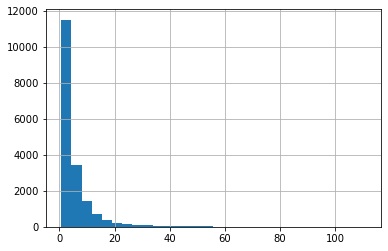

In [34]:
train_data['FEATURE_169'].hist(bins=30);

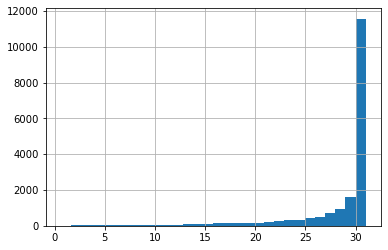

In [35]:
train_data['FEATURE_170'].hist(bins=30);

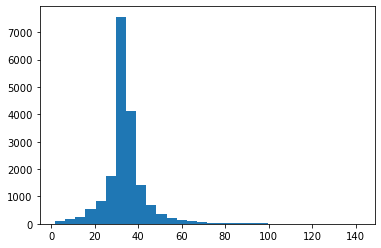

In [36]:
plt.hist(train_data['FEATURE_169'] + train_data['FEATURE_170'], bins=30);

In [37]:
# В датасете встречаются последовательности вещественных чисел с высокой корреляцией внутри последовательности
# Например FEATURE_33...FEATURE_38, FEATURE_45...FEATURE_56, FEATURE_57...FEATURE_68, FEATURE_77...FEATURE_109, 
# FEATURE_160...FEATURE_164, FEATURE_235...FEATURE_237
# Возможно, некоторые из них отображают значение некоторой величины в какие-то моменты времени
train_data.loc[:, 'FEATURE_33':'FEATURE_38']

,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38
0,45.595312,31.056361,61.251668,27.044580,-30.549305,64.179404
1,-44.228516,2.888951,-29.363987,-28.446865,9.735043,5.279001
2,32.411244,-49.744630,-10.413498,12.433387,3.289848,-21.593674
3,779.596729,1484.581743,486.919976,2031.418602,1618.459961,1890.229870
4,119.828164,582.644326,126.671766,1160.607919,154.848770,896.661311
...,...,...,...,...,...,...
18385,39.192931,77.232524,8.554933,8.783650,50.978910,-6.321936
18386,-11.851062,10.976155,-58.224808,-15.148772,-57.351935,16.429314
18387,-29.743284,2.280882,42.448577,-6.524298,47.533517,9.311252
18388,-43.176885,-6.988545,16.298207,11.214693,56.670335,-17.432198


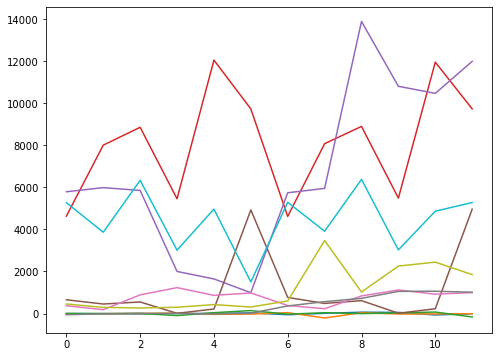

In [38]:
# Две из этих последовательностей (FEATURE_45...FEATURE_56 и FEATURE_57...FEATURE_68) состоят из 12 значений:
# возможно, значения некоторой величины по месяцам или по часам?
plt.figure(figsize=(8, 6));
for i in range(10, 20):
    plt.plot(train_data.loc[i, 'FEATURE_45':'FEATURE_56'].values)

In [39]:
#train_data.to_csv(PATH + 'train_data.csv', index=False)
#test_data.to_csv(PATH + 'test_data.csv', index=False)

In [40]:
#train_data = pd.read_csv(PATH + 'train_data.csv')
#test_data = pd.read_csv(PATH + 'test_data.csv')

# Feature Engineering

Добавим новые признаки: суммы значений признаков в найденных ранее последовательностях.

In [41]:
train_data['SUM_33_38'] = np.sum(train_data.iloc[:, 33:39], axis=1).values
test_data['SUM_33_38'] = np.sum(test_data.iloc[:, 33:39], axis=1).values

train_data['SUM_45_56'] = np.sum(train_data.iloc[:, 45:57], axis=1).values
test_data['SUM_45_56'] = np.sum(test_data.iloc[:, 45:57], axis=1).values

train_data['SUM_57_68'] = np.sum(train_data.iloc[:, 57:69], axis=1).values
test_data['SUM_57_68'] = np.sum(test_data.iloc[:, 57:69], axis=1).values

train_data['SUM_77_109'] = np.sum(train_data.iloc[:, 77:110], axis=1).values
test_data['SUM_77_109'] = np.sum(test_data.iloc[:, 77:110], axis=1).values

train_data['SUM_160_164'] = np.sum(train_data.iloc[:, 160:165], axis=1).values
test_data['SUM_160_164'] = np.sum(test_data.iloc[:, 160:165], axis=1).values

train_data['SUM_235_237'] = np.sum(train_data.iloc[:, 235:238], axis=1).values
test_data['SUM_235_237'] = np.sum(test_data.iloc[:, 235:238], axis=1).values

train_data['SUM_69_70'] = train_data['FEATURE_69'] + train_data['FEATURE_70']
test_data['SUM_69_70'] = test_data['FEATURE_69'] + test_data['FEATURE_70']

# Добавление этого признака не оказало положительного влияние на качество моделей
#train_data['SUM_169_170'] = train_data['FEATURE_169'] + train_data['FEATURE_170']
#test_data['SUM_169_170'] = test_data['FEATURE_169'] + test_data['FEATURE_170']

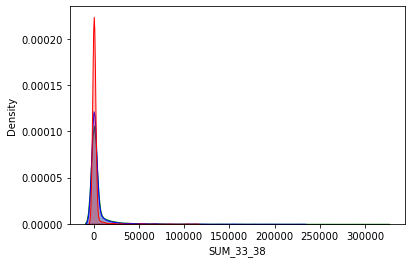

In [42]:
sns.kdeplot(train_data['SUM_33_38'][train_data['TARGET'] == 0], color='green', shade=True);
sns.kdeplot(train_data['SUM_33_38'][train_data['TARGET'] == 1], color='blue', shade=True);
sns.kdeplot(train_data['SUM_33_38'][train_data['TARGET'] == 2], color='red', shade=True);

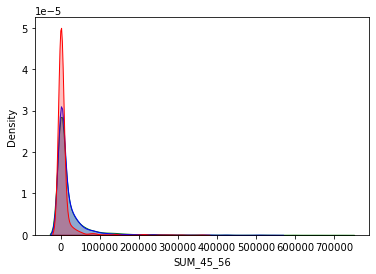

In [43]:
sns.kdeplot(train_data['SUM_45_56'][train_data['TARGET'] == 0], color='green', shade=True);
sns.kdeplot(train_data['SUM_45_56'][train_data['TARGET'] == 1], color='blue', shade=True);
sns.kdeplot(train_data['SUM_45_56'][train_data['TARGET'] == 2], color='red', shade=True);

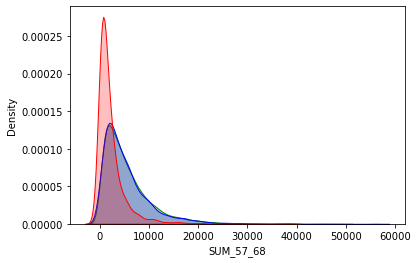

In [44]:
sns.kdeplot(train_data['SUM_57_68'][train_data['TARGET'] == 0], color='green', shade=True);
sns.kdeplot(train_data['SUM_57_68'][train_data['TARGET'] == 1], color='blue', shade=True);
sns.kdeplot(train_data['SUM_57_68'][train_data['TARGET'] == 2], color='red', shade=True);

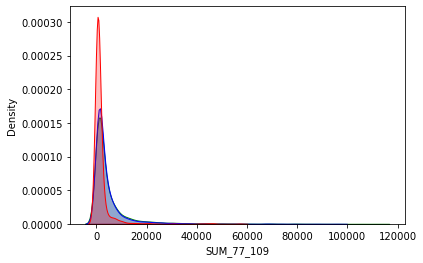

In [45]:
sns.kdeplot(train_data['SUM_77_109'][train_data['TARGET'] == 0], color='green', shade=True);
sns.kdeplot(train_data['SUM_77_109'][train_data['TARGET'] == 1], color='blue', shade=True);
sns.kdeplot(train_data['SUM_77_109'][train_data['TARGET'] == 2], color='red', shade=True);

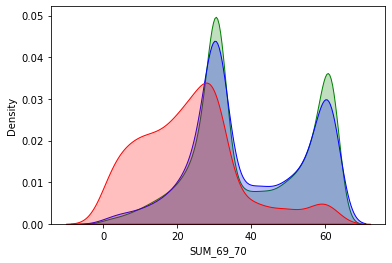

In [46]:
sns.kdeplot(train_data['SUM_69_70'][train_data['TARGET'] == 0], color='green', shade=True);
sns.kdeplot(train_data['SUM_69_70'][train_data['TARGET'] == 1], color='blue', shade=True);
sns.kdeplot(train_data['SUM_69_70'][train_data['TARGET'] == 2], color='red', shade=True);

Можем заметить, что введенные признаки оказывают влияние на принадлежность объекта к классу.

# Train / Test split

In [47]:
y = train_data['TARGET']
train_data.drop(['TARGET', 'ID'], axis=1, inplace=True)
id_labels = test_data['ID']
test_data.drop(['ID'], axis=1, inplace=True)
X_test = test_data

In [48]:
# Выделим 25% учебного датасета для оценки качества модели
X_train, X_valid, y_train, y_valid = train_test_split(train_data, y, test_size=VALID_SIZE, random_state=SEED)

In [49]:
# Создадим отмасштабированные датасеты  - для LogReg, KNN и SVM
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_valid_scaled = X_valid.copy()

for col in X_train_scaled.columns:
    X_train_scaled[col] = X_train_scaled[col].fillna(X_train_scaled[col].mean())
    X_test_scaled[col] = X_test_scaled[col].fillna(X_test_scaled[col].mean())
    X_valid_scaled[col] = X_valid_scaled[col].fillna(X_valid_scaled[col].mean())

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_all = np.vstack((X_train_scaled, X_test_scaled, X_valid_scaled))
scaler.fit(X_all)
X_train_scaled = scaler.transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)
X_valid_scaled = scaler.transform(X_valid_scaled)

eval_size = int(X_train.shape[0] * VALID_SIZE)

In [50]:
# Функция для вывода информации о важности признаков в построенной модели
def print_feat_imp(feat_names, feat_values, n_features=0, draw_bar=True, print_val=False):
    feat_imp = dict(zip(feat_names, feat_values))
    feat_dict = sorted(feat_imp.items(), key=lambda item: abs(item[1]), reverse=True)
    if not n_features:
        n_features = len(feat_values)
    if print_val:    
        { print('{}: {:.6f}'.format(k, v)) for k, v in feat_dict[:n_features] }
    if draw_bar:
        plt.figure(figsize=(10, 8));
        bar = sns.barplot(y=list(map(lambda x: x[0], feat_dict))[:n_features], \
            x=list(map(lambda x: x[1], feat_dict))[:n_features],
            orient='h');
        bar.set(title='Feature importance')

Обучим несколько различных моделей и проверим их качество на валидационном датасете

# Model 1: LogRegression

In [51]:
from sklearn.linear_model import LogisticRegression

X_train_lr = X_train_scaled.copy()
X_valid_lr = X_valid_scaled.copy()
X_test_lr = X_test_scaled.copy()

In [52]:
param_grid={'C': [0.001, 0.0025, 0.005, 0.01],
            'penalty': ['l1', 'l2'] }

In [53]:
estimator = LogisticRegression(class_weight='balanced') 
optimizer_lr = GridSearchCV(estimator, scoring='f1_macro', param_grid = param_grid, cv=5, n_jobs=-1, verbose=True)
optimizer_lr.fit(X_train_lr, y_train)
optimizer_lr.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.1s finished


{'C': 0.0025, 'penalty': 'l2'}

In [54]:
pred_valid_lr = optimizer_lr.predict(X_valid_lr)
proba_valid_lr = optimizer_lr.predict_proba(X_valid_lr)
f1_score(y_valid, pred_valid_lr, average='macro')

0.48016257918282707

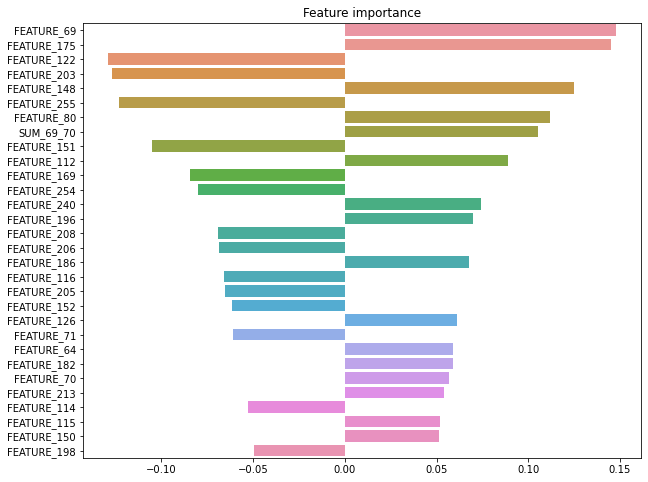

In [55]:
print_feat_imp(X_train.columns, optimizer_lr.best_estimator_.coef_[0], n_features=30)

# Model 2: KNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors' : [5, 10, 20],
              'weights' : ['uniform', 'distance'] }

In [58]:
knn_grid = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid = param_grid, cv=5, n_jobs=-1, verbose=True)
knn_grid.fit(X_train_scaled, y_train)
knn_grid.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


{'n_neighbors': 20, 'weights': 'uniform'}

In [59]:
pred_valid_knn = knn_grid.predict(X_valid_scaled)
proba_valid_knn = knn_grid.predict_proba(X_valid_scaled)
f1_score(y_valid, pred_valid_knn, average='macro')

0.3501569554892227

# Model 3: SVM

In [60]:
from sklearn import svm

In [61]:
1/ (pd.Series(y).value_counts() / len(y))

0     1.411467
1     4.340335
2    16.361210
Name: TARGET, dtype: float64

In [62]:
param_grid = {'class_weight': ['balanced', {0: 1.41, 1: 4.34, 2: 16.36}] }

In [1385]:
svm_grid = GridSearchCV(svm.SVC(random_state=SEED, verbose=True), \
                        param_grid = param_grid, cv=5, n_jobs=-1, verbose=True)
svm_grid.fit(X_train_scaled, y_train)
svm_grid.best_params_

In [1388]:
pred_valid_svm = svm_grid.predict(X_valid_scaled)
f1_score(y_valid, pred_valid_svm, average='macro')

0.5247093221576542

In [1389]:
pd.Series(pred_valid_svm).value_counts()

0    3164
1    1089
2     345
dtype: int64

# Model 4: RandomForest

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
X_train_rf = X_train.copy().fillna(0)
X_test_rf = X_test.copy().fillna(0)
X_valid_rf = X_valid.copy().fillna(0)

In [65]:
param_grid = { 'max_depth' : range(10, 13) }

In [66]:
rf_grid = GridSearchCV(RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=SEED), \
                       param_grid = param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=True)
rf_grid.fit(X_train_rf, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   15.7s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   27.2s finished


0.5090087726033394 {'max_depth': 10}


In [67]:
pred_valid_rf = rf_grid.predict(X_valid_rf)
proba_valid_rf = rf_grid.predict_proba(X_valid_rf)
f1_score(y_valid, pred_valid_rf, average='macro')

0.5186460982095741

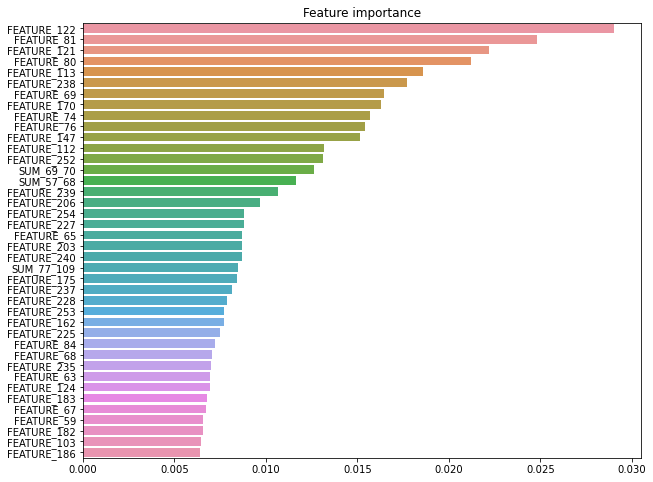

In [68]:
print_feat_imp(X_train.columns, rf_grid.best_estimator_.feature_importances_, n_features=40)

In [69]:
pd.Series(pred_valid_rf).value_counts()

0    3037
1    1191
2     370
dtype: int64

# Model 5: XGBoost

In [70]:
from xgboost import XGBClassifier
xgb = XGBClassifier(objective='multi:softmax', max_depth=7, seed=SEED, n_jobs=-1)

xgb.fit(X_train[:-eval_size], y_train[:-eval_size], \
        eval_metric='auc', \
        eval_set=[(X_train[:-eval_size], y_train[:-eval_size]), (X_train[-eval_size:], y_train[-eval_size:])], \
          verbose=5, early_stopping_rounds=20)

C:\Div\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.79094	validation_1-auc:0.66256
[5]	validation_0-auc:0.91305	validation_1-auc:0.68802
[10]	validation_0-auc:0.95695	validation_1-auc:0.69755
[15]	validation_0-auc:0.97825	validation_1-auc:0.70220
[20]	validation_0-auc:0.98875	validation_1-auc:0.70056
[25]	validation_0-auc:0.99328	validation_1-auc:0.70232
[30]	validation_0-auc:0.99682	validation_1-auc:0.70344
[35]	validation_0-auc:0.99877	validation_1-auc:0.69995
[40]	validation_0-auc:0.99957	validation_1-auc:0.69606
[45]	validation_0-auc:0.99987	validation_1-auc:0.69395
[49]	validation_0-auc:0.99997	validation_1-auc:0.69268


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=18, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=18, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [71]:
pred_valid_xgb = xgb.predict(X_valid)
f1_score(y_valid, pred_valid_xgb, average='macro')

0.46197494108164

# Model 6: CatBoost

In [72]:
from catboost import CatBoostClassifier

X_train_ctb = X_train.copy()
X_test_ctb = X_test.copy()
X_valid_ctb = X_valid.copy()

In [73]:
ctb = CatBoostClassifier(depth=8, iterations=120, random_seed=SEED, learning_rate=0.16, \
                         loss_function='MultiClass', eval_metric='TotalF1', auto_class_weights='Balanced')

ctb.fit(X_train_ctb[:-eval_size], y_train[:-eval_size], \
        eval_set=(X_train_ctb[-eval_size:], y_train[-eval_size:]), \
        plot=True, verbose=10)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5380540	test: 0.4930622	best: 0.4930622 (0)	total: 350ms	remaining: 41.7s
10:	learn: 0.6264553	test: 0.5761635	best: 0.5761635 (10)	total: 2.54s	remaining: 25.2s
20:	learn: 0.6571083	test: 0.5740755	best: 0.5778182 (13)	total: 4.73s	remaining: 22.3s
30:	learn: 0.6911605	test: 0.5677483	best: 0.5778182 (13)	total: 6.94s	remaining: 19.9s
40:	learn: 0.7242299	test: 0.5691888	best: 0.5785824 (35)	total: 9.13s	remaining: 17.6s
50:	learn: 0.7504631	test: 0.5668617	best: 0.5785824 (35)	total: 11.4s	remaining: 15.4s
60:	learn: 0.7716876	test: 0.5688444	best: 0.5785824 (35)	total: 13.5s	remaining: 13.1s
70:	learn: 0.7991866	test: 0.5774945	best: 0.5785824 (35)	total: 15.7s	remaining: 10.9s
80:	learn: 0.8212745	test: 0.5784597	best: 0.5800366 (75)	total: 17.9s	remaining: 8.63s
90:	learn: 0.8418886	test: 0.5775338	best: 0.5800366 (75)	total: 20.2s	remaining: 6.43s
100:	learn: 0.8584817	test: 0.5806100	best: 0.5808824 (94)	total: 22.4s	remaining: 4.21s
110:	learn: 0.8739670	test: 0.577

In [74]:
pred_valid_ctb = ctb.predict(X_valid_ctb)
proba_valid_ctb = ctb.predict_proba(X_valid_ctb)
f1_score(y_valid, pred_valid_ctb, average='macro')

0.5269839072586535

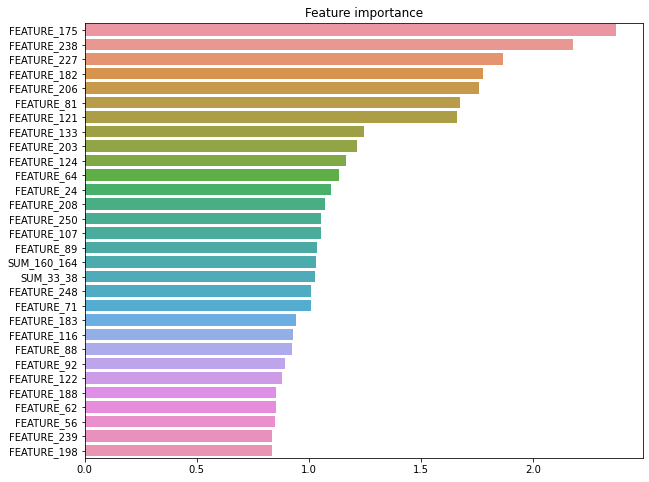

In [75]:
print_feat_imp(X_train.columns, ctb.get_feature_importance(), n_features=30)

Таким образом, наилучшие результаты с точки зрения метрики macro_f_score показали:
- CatBoost: 0.5269
- SVM: 0.5247
- RandomForest: 0.5186

В то же время, SVM продемонстрировал самую низкую скорость работы, а вероятности отнесения к классу, которые он выдает, сложно интерпретировать.

Посмотрим на взаимосвязь вероятностей отнесения к классу для CatBoost и RandomForest:

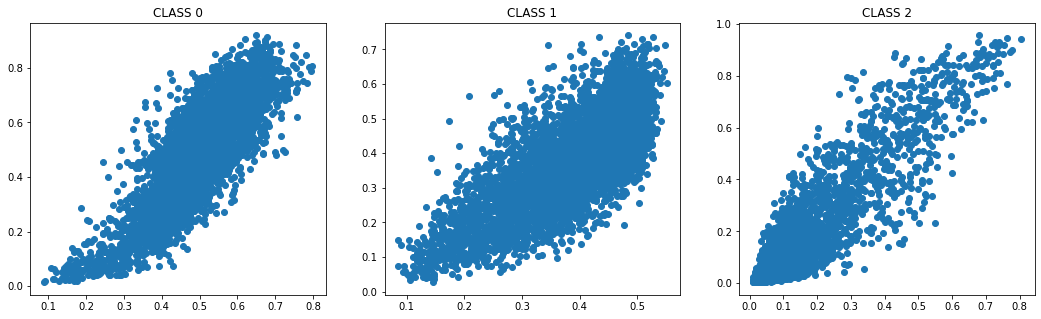

In [76]:
plt.figure(figsize = (18, 5))
for label in range(3):
    plt.subplot(1, 3, label+1)
    plt.scatter(proba_valid_rf[:, label], proba_valid_ctb[:, label]);
    plt.title('CLASS ' + str(label))

Построим ансамбль из перечисленных двух моделей и возьмем в качестве вероятности отнесения объекта к классу среднее значение из предсказанных двумя моделями вероятностей.

In [77]:
def pred_ensemble(proba_1, proba_2):
    proba_final = proba_1 + proba_2
    pred_final = []
    for i in range(len(proba_final)):
        max_el = max(proba_final[i])
        pred_final.append(np.where(proba_final[i] == max_el)[0][0])
    return pred_final

In [78]:
pred_ens = pred_ensemble(proba_valid_rf, proba_valid_ctb)
f1_score(y_valid, pred_ens, average='macro')

0.5369602236238588

Таким образом, удалось еще немного улучшить результат предсказания для валидационной выборки. Построим итоговую модель и сделаем предсказание для тестовой выборки.

# Ensembling

In [79]:
X_train_rf_final = train_data.fillna(0)
X_test_rf_final = test_data.fillna(0)

In [80]:
param_grid = { 'max_depth' : range(10, 13) }

rf_grid_final = GridSearchCV(RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=SEED), \
                       param_grid = param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=True)

rf_grid_final.fit(X_train_rf_final, y)
print(rf_grid_final.best_score_, rf_grid_final.best_params_)
pred_rf = rf_grid_final.predict(X_test_rf_final)
proba_rf = rf_grid_final.predict_proba(X_test_rf_final)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   21.6s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   37.4s finished


0.5108886810524786 {'max_depth': 11}


In [81]:
X_train_ctb_final = train_data.copy()
X_test_ctb_final = test_data.copy()

In [82]:
ctb_final = CatBoostClassifier(depth=8, iterations=120, random_seed=SEED, learning_rate=0.16, \
                         loss_function='MultiClass', eval_metric='TotalF1', auto_class_weights='Balanced')

ctb_final.fit(X_train_ctb_final, y, plot=True, verbose=10)

pred_ctb = ctb_final.predict(X_test_ctb_final)
proba_ctb = ctb_final.predict_proba(X_test_ctb_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5193256	total: 231ms	remaining: 27.5s
10:	learn: 0.6069404	total: 2.71s	remaining: 26.9s
20:	learn: 0.6413855	total: 5.18s	remaining: 24.4s
30:	learn: 0.6672766	total: 7.68s	remaining: 22.1s
40:	learn: 0.6880176	total: 10.2s	remaining: 19.6s
50:	learn: 0.7068103	total: 12.6s	remaining: 17.1s
60:	learn: 0.7285184	total: 15.1s	remaining: 14.6s
70:	learn: 0.7477071	total: 17.5s	remaining: 12.1s
80:	learn: 0.7629489	total: 20s	remaining: 9.61s
90:	learn: 0.7809488	total: 22.3s	remaining: 7.12s
100:	learn: 0.7946622	total: 24.8s	remaining: 4.66s
110:	learn: 0.8104576	total: 27.2s	remaining: 2.21s
119:	learn: 0.8226321	total: 29.4s	remaining: 0us


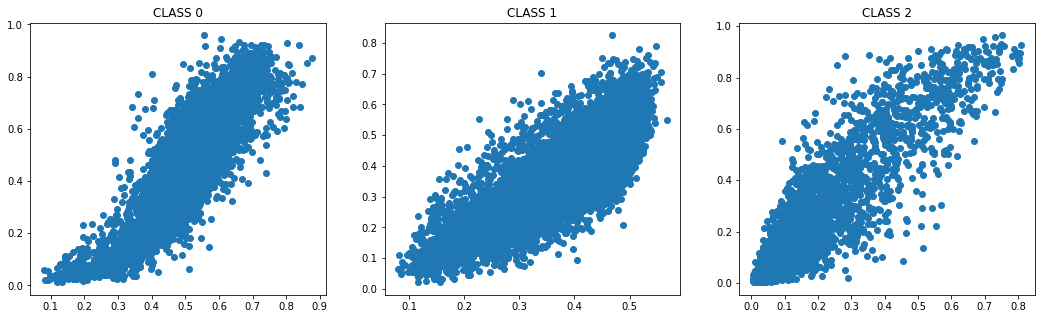

In [83]:
plt.figure(figsize = (18, 5))
for label in range(3):
    plt.subplot(1, 3, label+1)
    plt.scatter(proba_rf[:, label], proba_ctb[:, label]);
    plt.title('CLASS ' + str(label))

In [84]:
pred_final = pred_ensemble(proba_rf, proba_ctb)

In [85]:
# Посмотрим на предсказанное количество объектов каждого класса
pd.Series(pred_final).value_counts()

0    3766
1    1774
2     591
dtype: int64

In [86]:
output = pd.DataFrame({'ID': id_labels.values, 'TARGET': pred_final})
output.to_csv(PATH + 'contest_answer.csv', sep=',', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
